In this notebook, we will analyze stock data sourced from Alpha Vantage. Our workflow will include:

   1. Feature Engineering – Creating meaningful features from raw stock data to enhance our analysis and modeling.

   2. Data Visualization – Exploring trends, patterns, and relationships in the data through visualizations.

   3. Predictive Modeling – Building a model to forecast stock behavior using the engineered features.

By the end of this notebook, we aim to uncover insights from historical stock data and demonstrate a predictive approach that can inform trading or investment decisions.

In [2]:
# Connect to AlphaVantage and collect stock data
import requests
from dotenv import load_dotenv
from os import getenv

load_dotenv()
API_KEY = getenv("ALPHAVANTAGE_API_KEY")

symbol = "SPY"
url = (f"https://www.alphavantage.co/query"
        + "?function=TIME_SERIES_DAILY"
        + f"&symbol={symbol}"
        + f"&apikey={API_KEY}"
        #+ "&outputsize=full"
      )
r = requests.get(url)
data = r.json()


In [3]:
# Print relevant metadata
print("DATA:         ", data.get("Meta Data").get("1. Information"))
print("SYMBOL:       ", data.get("Meta Data").get("2. Symbol"))
print("REFRESH DATE: ", data.get("Meta Data").get("3. Last Refreshed"))

DATA:          Daily Prices (open, high, low, close) and Volumes
SYMBOL:        SPY
REFRESH DATE:  2025-10-24


In [4]:
# Load data into a pandas DataFrame
import pandas as pd

df = pd.DataFrame.from_dict(data.get("Time Series (Daily)"), orient='index')
df.index.name = 'date'
df.reset_index(inplace=True)
df.columns = ['date', 'open', 'high', 'low', 'close', 'volume']

print(df)

          date      open      high       low     close    volume
0   2025-10-24  676.4600  678.4700  675.6500  677.2500  74356527
1   2025-10-23  668.1200  672.7101  667.8000  671.7600  65604461
2   2025-10-22  672.0000  672.0000  663.3000  667.8000  80564006
3   2025-10-21  671.4400  672.9900  669.9810  671.2900  56249034
4   2025-10-20  667.3200  672.2100  667.2700  671.3000  60493350
..         ...       ...       ...       ...       ...       ...
95  2025-06-10  600.2200  603.4700  599.0900  603.0800  66246973
96  2025-06-09  599.7200  601.2500  598.4900  599.6800  53016418
97  2025-06-06  598.6600  600.8300  596.8600  599.1400  66588743
98  2025-06-05  597.6300  599.0000  591.0500  593.0500  92436397
99  2025-06-04  596.9600  597.9500  595.4900  595.9300  57314199

[100 rows x 6 columns]


In [5]:
# Convert columns to float
df['open'] = df['open'].astype(float)
df['close'] = df['close'].astype(float)
df['volume'] = df['volume'].astype(float)
df['high'] = df['high'].astype(float)
df['low'] = df['low'].astype(float)

In [6]:
import numpy as np

df["day's range"] = df['close'] - df['open']
df['price difference'] = df['high'] - df['low']
df['day to day'] = df['close'] - df['open'].shift(1)
df['log returns'] = np.log(df['close'] / df['close'].shift(1))                       

In [7]:
# Overall range
overall_range = df['close'].max() - df['open'].min()
print("Overall Open-to-Close Range:", overall_range)

Overall Open-to-Close Range: 82.21000000000004


In [8]:
df.head(2)

,date,open,high,low,close,volume,day's range,price difference,day to day,log returns
0,2025-10-24,676.46,678.4700,675.65,677.25,74356527.0,0.79,2.8200,NaN,NaN
1,2025-10-23,668.12,672.7101,667.80,671.76,65604461.0,3.64,4.9101,-4.7,-0.008139


In [9]:
# Sort by date just in case
df = df.sort_values('date')

# Day-to-day volume change
df['volume_change'] = df['volume'] - df['volume'].shift(1)

# Optional: percentage change
df['volume_pct_change'] = df['volume'].pct_change() * 100

# Calculate Price / Volume for each row (using Close price)
df['price by volume'] = df['close'] / df['volume']

In [10]:
# Initialize OBV
df['obv'] = 0

# Loop method with .loc
for i in range(1, len(df)):
    if df['close'].iloc[i] > df['close'].iloc[i-1]:
        df.loc[i, 'obv'] = df.loc[i-1, 'obv'] + df.loc[i, 'volume']
    elif df['close'].iloc[i] < df['close'].iloc[i-1]:
        df.loc[i, 'obv'] = df.loc[i-1, 'obv'] - df.loc[i, 'volume']
    else:
        df.loc[i, 'obv'] = df.loc[i-1, 'obv']

# 7-day moving average of volume
df['volume_ma7'] = df['volume'].rolling(window=7).mean()

In [11]:
df.head(2)

,date,open,high,low,close,volume,day's range,price difference,day to day,log returns,volume_change,volume_pct_change,price by volume,obv,volume_ma7
99,2025-06-04,596.96,597.95,595.49,595.93,57314199.0,-1.03,2.46,-1.70,0.004844,NaN,NaN,0.000010,682917789,NaN
98,2025-06-05,597.63,599.00,591.05,593.05,92436397.0,-4.58,7.95,-5.61,-0.010217,35122198.0,61.280099,0.000006,625603590,NaN


In [12]:
# Create lag features for close and volume
lag_days = [1, 2, 3]  # 1-day, 2-day, 3-day lags

for lag in lag_days:
    df[f'close_lag_{lag}'] = df['close'].shift(lag)
    df[f'volume_lag_{lag}'] = df['volume'].shift(lag)
    df[f'price_by_volume_lag_{lag}'] = (df['close'] * df['volume']).shift(lag)

# View result
print(df[['date', 'close', 'close_lag_1', 'close_lag_2', 'close_lag_3',
          'volume', 'volume_lag_1', 'volume_lag_2', 'volume_lag_3']])

          date   close  close_lag_1  close_lag_2  close_lag_3      volume  \
99  2025-06-04  595.93          NaN          NaN          NaN  57314199.0   
98  2025-06-05  593.05       595.93          NaN          NaN  92436397.0   
97  2025-06-06  599.14       593.05       595.93          NaN  66588743.0   
96  2025-06-09  599.68       599.14       593.05       595.93  53016418.0   
95  2025-06-10  603.08       599.68       599.14       593.05  66246973.0   
..         ...     ...          ...          ...          ...         ...   
4   2025-10-20  671.30       664.39       660.64       665.17  60493350.0   
3   2025-10-21  671.29       671.30       664.39       660.64  56249034.0   
2   2025-10-22  667.80       671.29       671.30       664.39  80564006.0   
1   2025-10-23  671.76       667.80       671.29       671.30  65604461.0   
0   2025-10-24  677.25       671.76       667.80       671.29  74356527.0   

    volume_lag_1  volume_lag_2  volume_lag_3  
99           NaN           N

                      close    volume  price by volume  log returns  \
close              1.000000 -0.000706         0.181002     0.118078   
volume            -0.000706  1.000000        -0.919134    -0.318001   
price by volume    0.181002 -0.919134         1.000000     0.275090   
log returns        0.118078 -0.318001         0.275090     1.000000   
day to day         0.041251 -0.201331         0.132048     0.522160   
volume_change     -0.059682  0.616486        -0.545517    -0.208908   
volume_pct_change -0.038519  0.664980        -0.607305    -0.199843   
obv               -0.782888 -0.072600        -0.116297    -0.135457   

                   day to day  volume_change  volume_pct_change       obv  
close                0.041251      -0.059682          -0.038519 -0.782888  
volume              -0.201331       0.616486           0.664980 -0.072600  
price by volume      0.132048      -0.545517          -0.607305 -0.116297  
log returns          0.522160      -0.208908          -0

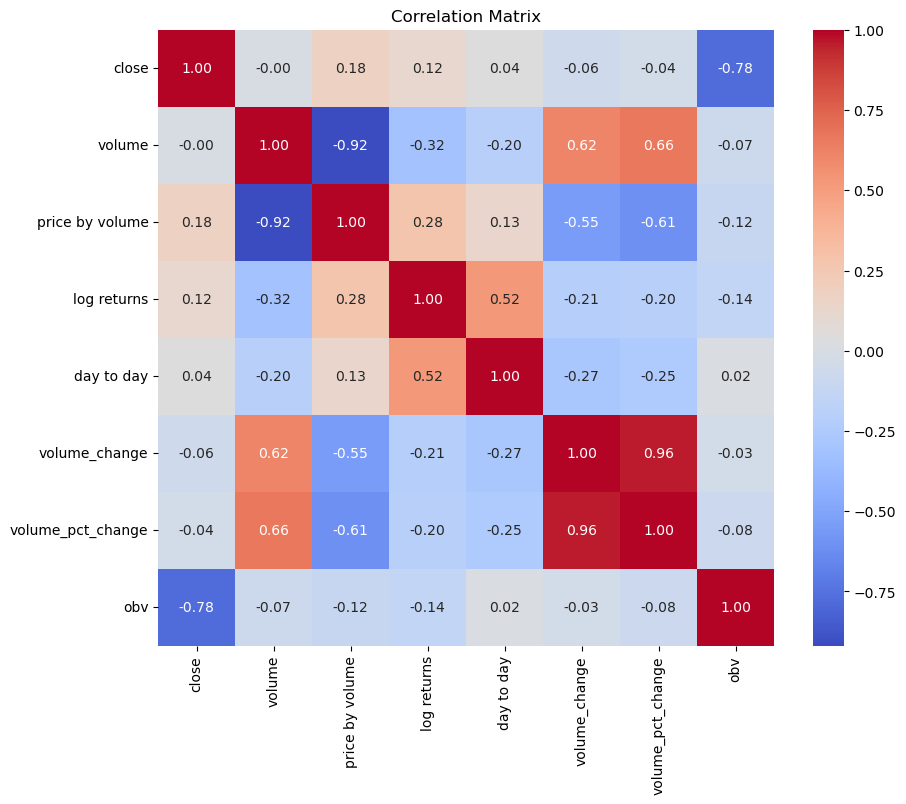

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select numeric columns you want to check correlations for
numeric_cols = ['close', 'volume', 'price by volume', 'log returns', 
                'day to day', 'volume_change', 'volume_pct_change', 'obv']

# Calculate correlation matrix
corr_matrix = df[numeric_cols].corr()

# Display correlation matrix
print(corr_matrix)

# Plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

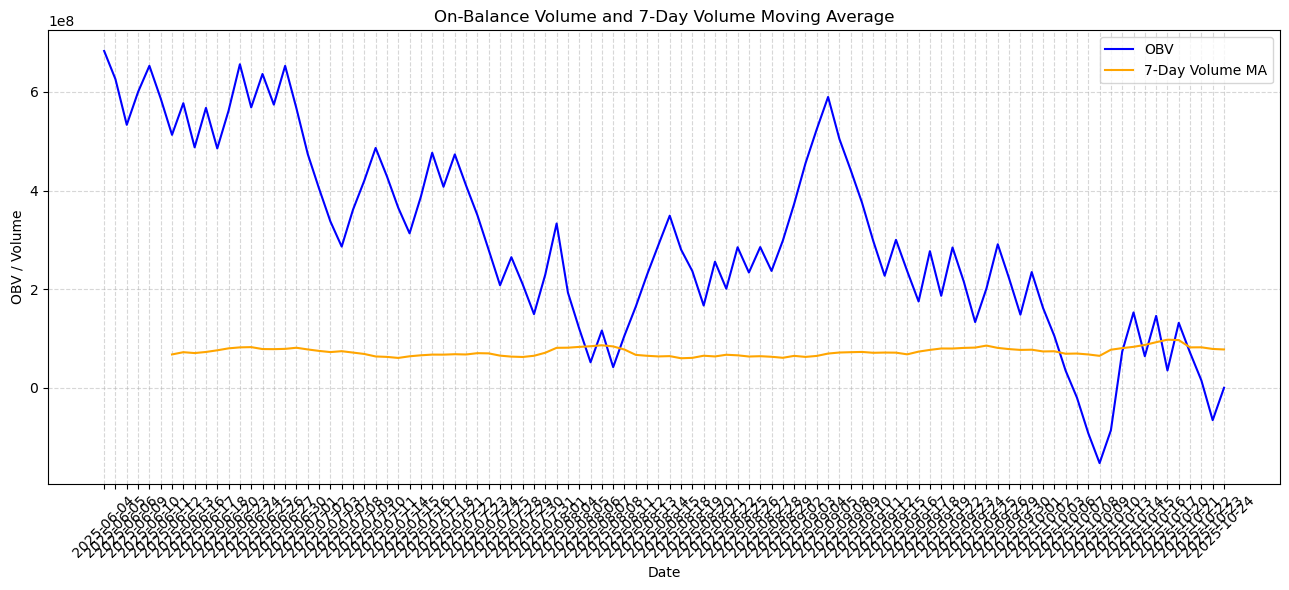

In [14]:
plt.figure(figsize=(13,6))

# OBV line
plt.plot(df['date'], df['obv'], color='blue', label='OBV')

# Volume moving average line
plt.plot(df['date'], df['volume_ma7'], color='orange', label='7-Day Volume MA')

plt.xlabel('Date')
plt.ylabel('OBV / Volume')
plt.title('On-Balance Volume and 7-Day Volume Moving Average')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

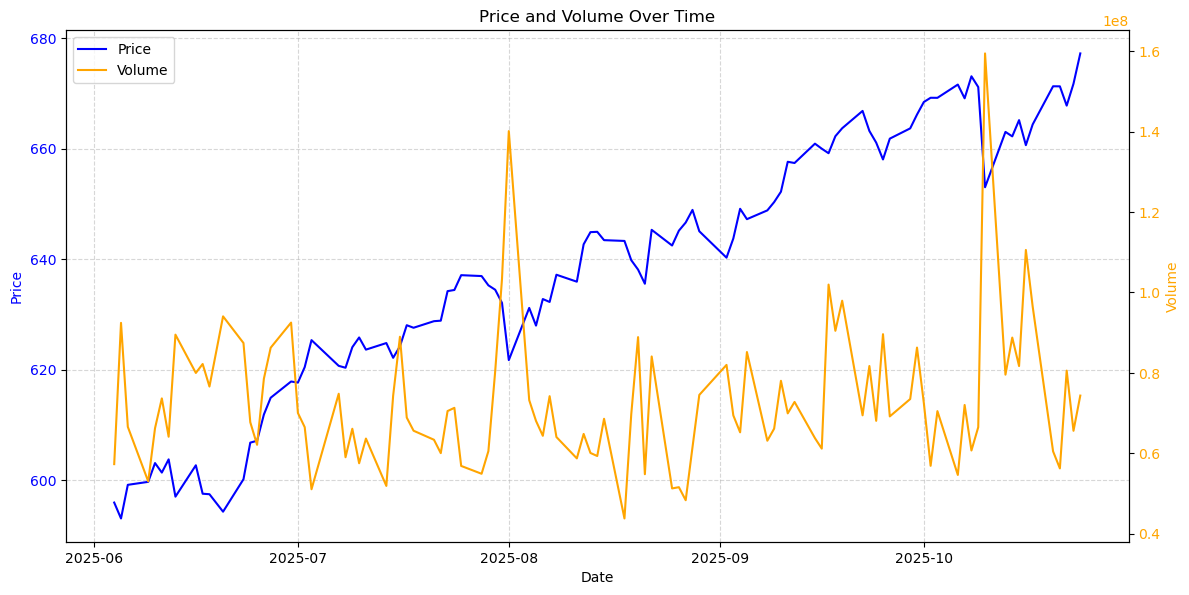

In [15]:
df['date'] = pd.to_datetime(df['date'])

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot price on left Y-axis
ax1.plot(df['date'], df['close'], color='blue', label='Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, linestyle='--', alpha=0.5)

# Create second Y-axis for volume
ax2 = ax1.twinx()
ax2.plot(df['date'], df['volume'], color='orange', label='Volume')
ax2.set_ylabel('Volume', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Title and legend
fig.tight_layout()
plt.title('Price and Volume Over Time')

# Show combined legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.show()

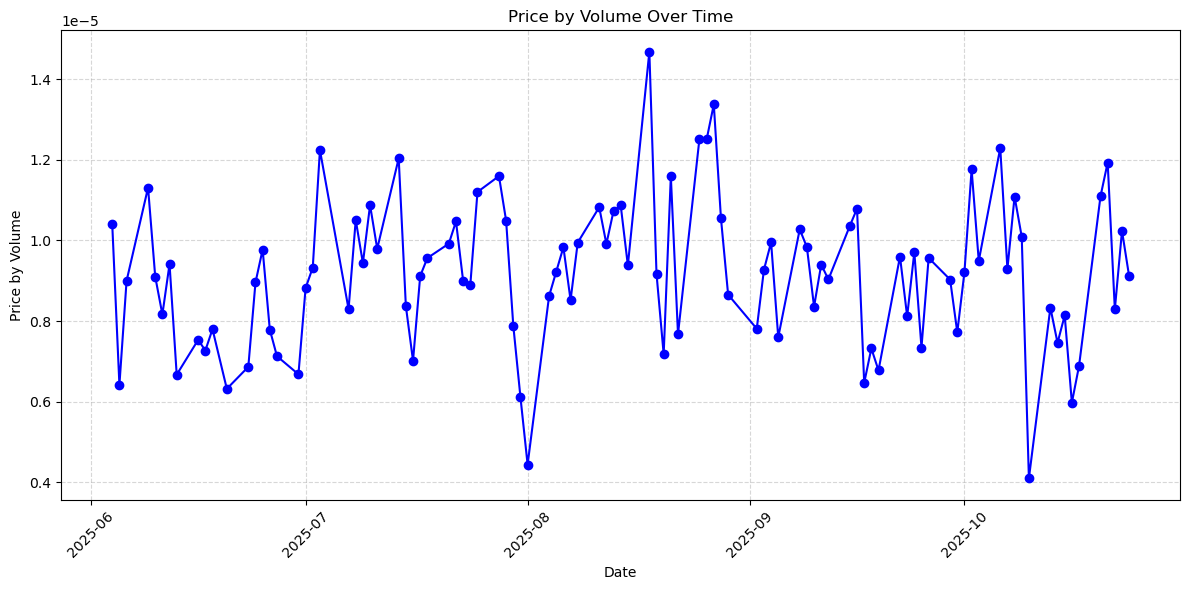

In [16]:
# Plot line graph
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['price by volume'], marker='o', linestyle='-', color='blue')
plt.xlabel('Date')
plt.ylabel('Price by Volume')
plt.title('Price by Volume Over Time')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

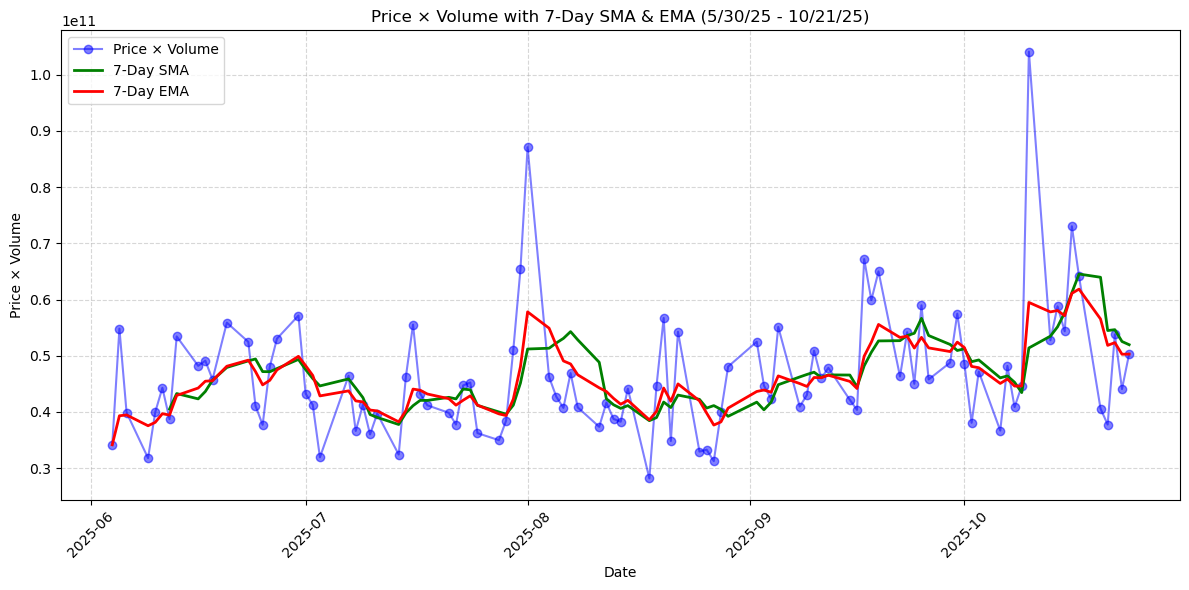

In [17]:
# Calculate Price × Volume
df['price by volume'] = df['close'] * df['volume']

# Calculate 7-day SMA
df['sma7'] = df['price by volume'].rolling(window=7).mean()

# Calculate 7-day EMA
df['ema7'] = df['price by volume'].ewm(span=7, adjust=False).mean()

# Plot
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['price by volume'], marker='o', linestyle='-', alpha=0.5, label='Price × Volume', color='blue')
plt.plot(df['date'], df['sma7'], color='green', linewidth=2, label='7-Day SMA')
plt.plot(df['date'], df['ema7'], color='red', linewidth=2, label='7-Day EMA')

plt.xlabel('Date')
plt.ylabel('Price × Volume')
plt.title('Price × Volume with 7-Day SMA & EMA (5/30/25 - 10/21/25)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

Bullish SMA crossovers:
          date          sma7         sma30
66 2025-07-23  4.407959e+10  4.407931e+10
60 2025-07-31  4.514351e+10  4.399792e+10
35 2025-09-05  4.484316e+10  4.431543e+10
10 2025-10-10  5.138942e+10  5.036063e+10
Bearish SMA crossovers:
          date          sma7         sma30
65 2025-07-24  4.393715e+10  4.425553e+10
52 2025-08-12  4.234517e+10  4.374212e+10
14 2025-10-06  4.606819e+10  4.701435e+10
0  2025-10-24  5.196492e+10  5.230126e+10
Bullish EMA crossovers:
          date          ema7         ema30
98 2025-06-05  3.932129e+10  3.548842e+10
71 2025-07-16  4.406862e+10  4.228551e+10
66 2025-07-23  4.208686e+10  4.202186e+10
61 2025-07-30  4.227436e+10  4.184345e+10
46 2025-08-20  4.425774e+10  4.389266e+10
44 2025-08-22  4.499088e+10  4.401465e+10
38 2025-09-02  4.364099e+10  4.285922e+10
10 2025-10-10  5.948557e+10  5.056069e+10
Bearish EMA crossovers:
          date          ema7         ema30
77 2025-07-08  4.196647e+10  4.222094e+10
67 2025-07-22  4.1

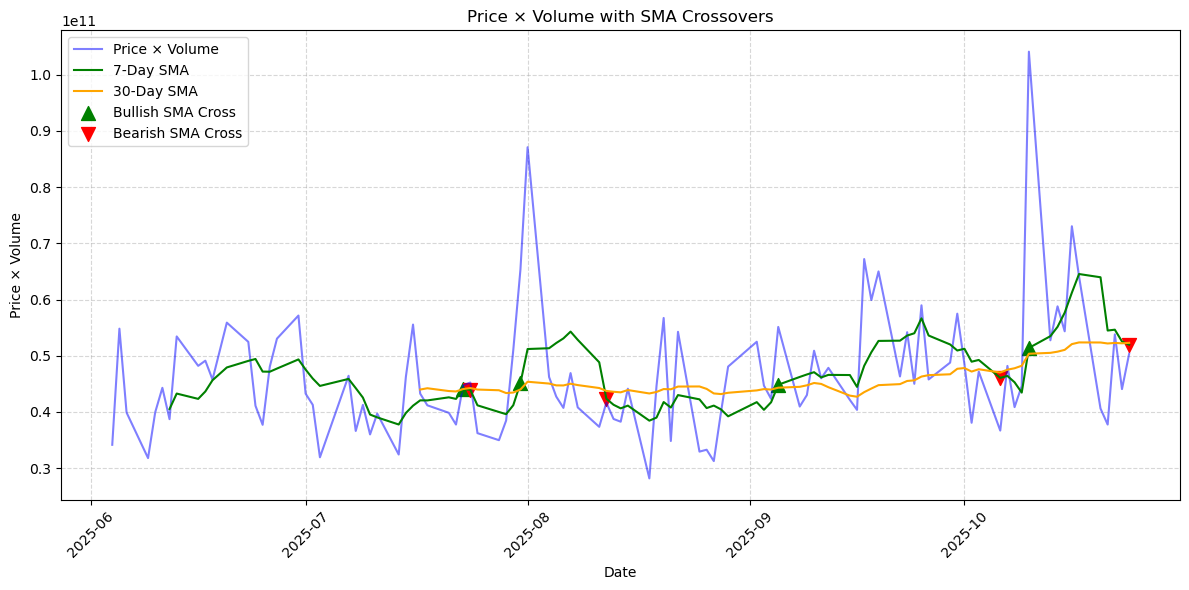

In [18]:
# Short-term and long-term SMAs
df['sma30'] = df['price by volume'].rolling(window=30).mean()

# Short-term and long-term EMAs
df['ema30'] = df['price by volume'].ewm(span=30, adjust=False).mean()

# Find crossover signals (SMA example)
df['sma_signal'] = np.where(df['sma7'] > df['sma30'], 1, 0)  # 1 = bullish, 0 = bearish
df['sma_crossover'] = df['sma_signal'].diff()  # 1 = buy, -1 = sell

# Find crossover signals (EMA example)
df['ema_signal'] = np.where(df['ema7'] > df['ema30'], 1, 0)
df['ema_crossover'] = df['ema_signal'].diff()

# Print crossover points
bullish_sma = df[df['sma_crossover'] == 1]
bearish_sma = df[df['sma_crossover'] == -1]

bullish_ema = df[df['ema_crossover'] == 1]
bearish_ema = df[df['ema_crossover'] == -1]

print("Bullish SMA crossovers:\n", bullish_sma[['date', 'sma7', 'sma30']])
print("Bearish SMA crossovers:\n", bearish_sma[['date', 'sma7', 'sma30']])
print("Bullish EMA crossovers:\n", bullish_ema[['date', 'ema7', 'ema30']])
print("Bearish EMA crossovers:\n", bearish_ema[['date', 'ema7', 'ema30']])

# Optional: plot SMA crossovers
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['price by volume'], color='blue', alpha=0.5, label='Price × Volume')
plt.plot(df['date'], df['sma7'], color='green', label='7-Day SMA')
plt.plot(df['date'], df['sma30'], color='orange', label='30-Day SMA')

# Mark bullish and bearish crossovers
plt.scatter(bullish_sma['date'], bullish_sma['sma7'], marker='^', color='g', s=100, label='Bullish SMA Cross')
plt.scatter(bearish_sma['date'], bearish_sma['sma7'], marker='v', color='r', s=100, label='Bearish SMA Cross')

plt.xlabel('Date')
plt.ylabel('Price × Volume')
plt.title('Price × Volume with SMA Crossovers')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

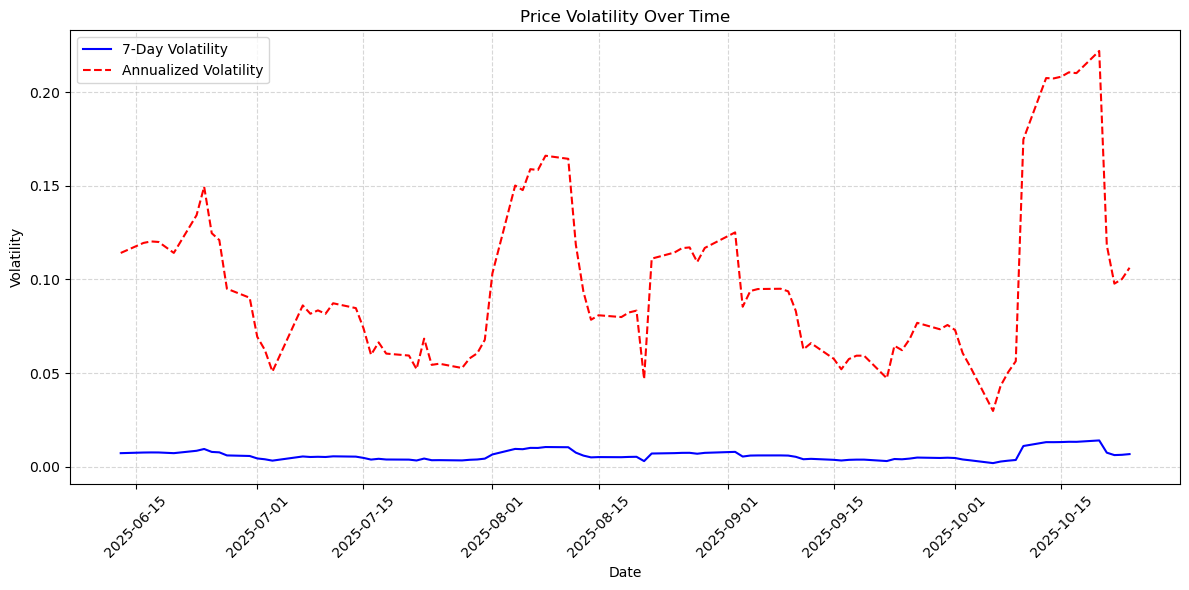

In [19]:
# Calculate daily returns
df['returns'] = df['close'].pct_change()

# Calculate rolling volatility (e.g., 7-day)
df['volatility_7d'] = df['returns'].rolling(window=7).std()

# Optional: annualized volatility (assuming 252 trading days)
df['volatility_annualized'] = df['volatility_7d'] * np.sqrt(252)

# Plot rolling volatility
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['volatility_7d'], label='7-Day Volatility', color='blue')
plt.plot(df['date'], df['volatility_annualized'], label='Annualized Volatility', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Price Volatility Over Time')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

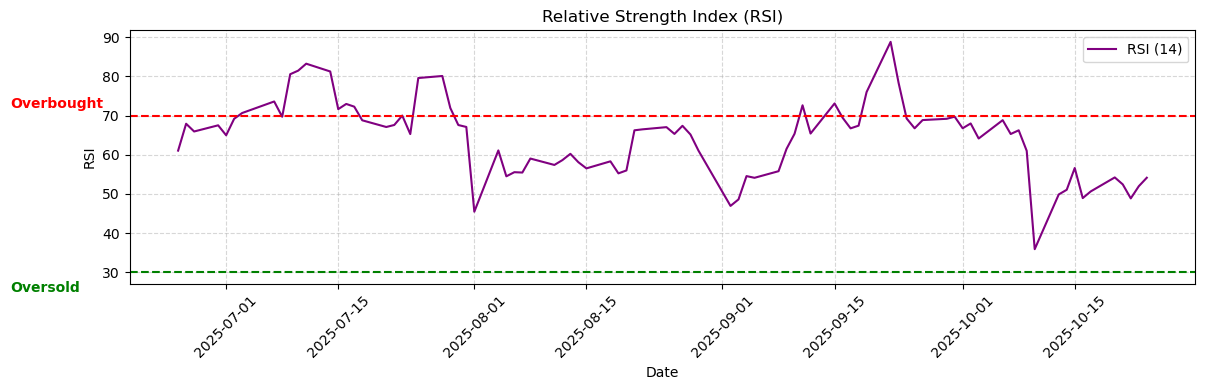

In [20]:
# Calculate daily returns
delta = df['close'].diff()

# Separate gains and losses
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)

# Calculate average gain/loss
window = 14
avg_gain = gain.rolling(window=window).mean()
avg_loss = loss.rolling(window=window).mean()

# Calculate RS and RSI
rs = avg_gain / avg_loss
df['rsi'] = 100 - (100 / (1 + rs))

# Plot RSI
plt.figure(figsize=(12,4))
plt.plot(df['date'], df['rsi'], color='purple', label='RSI (14)')
plt.axhline(70, color='red', linestyle='--')  # overbought
plt.axhline(30, color='green', linestyle='--')  # oversold
plt.text(df['date'].iloc[0], 70+2, 'Overbought', color='red', fontsize=10, fontweight='bold')
plt.text(df['date'].iloc[0], 30-5, 'Oversold', color='green', fontsize=10, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.title('Relative Strength Index (RSI)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

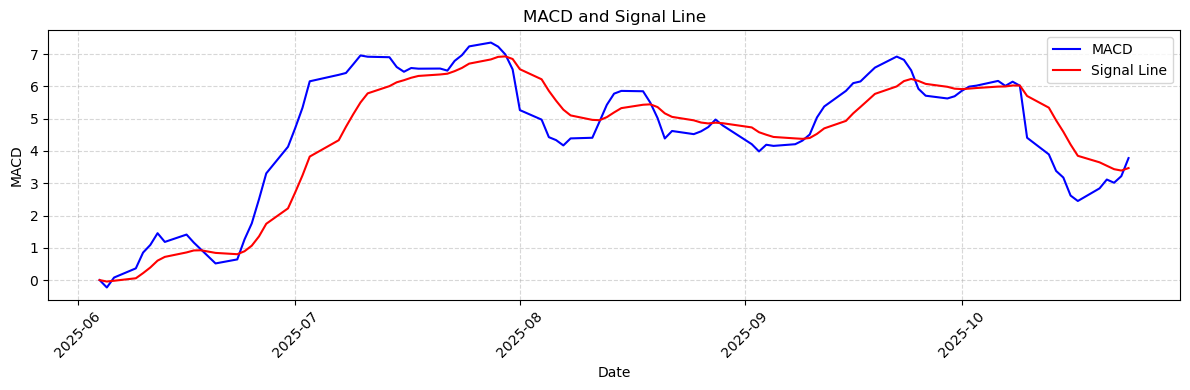

In [21]:
# Calculate MACD
ema12 = df['close'].ewm(span=12, adjust=False).mean()
ema26 = df['close'].ewm(span=26, adjust=False).mean()
df['macd'] = ema12 - ema26

# Signal line
df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()

# Plot MACD
plt.figure(figsize=(12,4))
plt.plot(df['date'], df['macd'], label='MACD', color='blue')
plt.plot(df['date'], df['macd_signal'], label='Signal Line', color='red')
plt.xlabel('Date')
plt.ylabel('MACD')
plt.title('MACD and Signal Line')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
# Ensure date is datetime
df['date'] = pd.to_datetime(df['date'])

# Create day of week column (0=Monday, 6=Sunday)
df['day_of_week'] = df['date'].dt.dayofweek

# Create day-of-week one-hot
df = pd.concat([df, pd.get_dummies(df['day_of_week'], prefix='dow')], axis=1)

# Check which columns exist
print(df.filter(like='dow_').columns)

Index(['dow_0', 'dow_1', 'dow_2', 'dow_3', 'dow_4'], dtype='object')


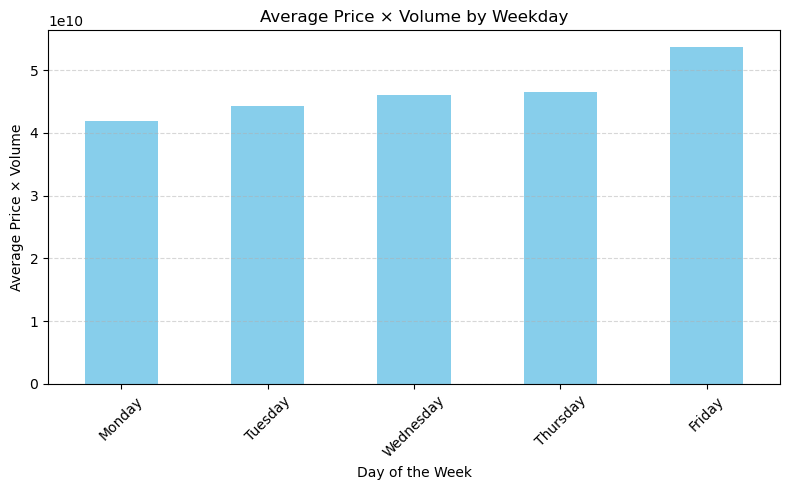

In [23]:
# Group by day_of_week and calculate average Price × Volume
avg_price_by_volume = df.groupby('day_of_week')['price by volume'].mean()

# Map day numbers to weekday names
weekday_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday'}
avg_price_by_volume.index = avg_price_by_volume.index.map(weekday_names)

# Plot
plt.figure(figsize=(8,5))
avg_price_by_volume.plot(kind='bar', color='skyblue')
plt.xlabel('Day of the Week')
plt.ylabel('Average Price × Volume')
plt.title('Average Price × Volume by Weekday')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

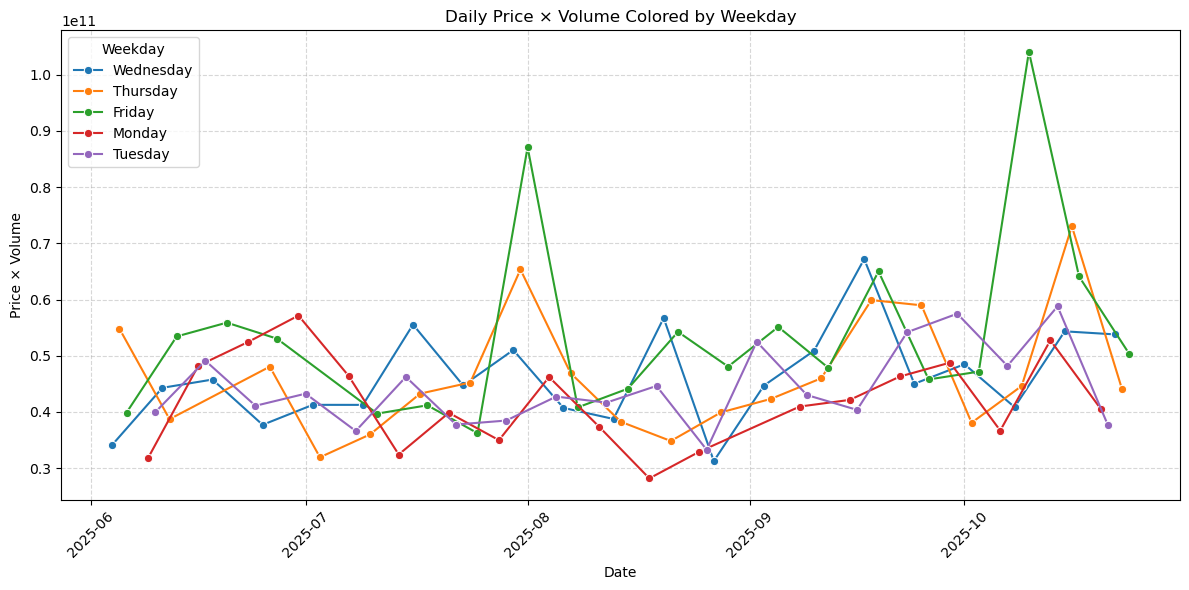

In [24]:
# Map numeric day_of_week to names
weekday_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday'}
df['weekday_name'] = df['day_of_week'].map(weekday_names)

# Set a color palette for weekdays
palette = sns.color_palette("tab10", n_colors=5)  # 5 weekdays

# Plot
plt.figure(figsize=(12,6))
sns.lineplot(data=df, x='date', y='price by volume', hue='weekday_name', palette=palette, marker='o')

plt.xlabel('Date')
plt.ylabel('Price × Volume')
plt.title('Daily Price × Volume Colored by Weekday')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Weekday')
plt.tight_layout()
plt.show()

In [25]:
#Average of close, volume by day of week
df.groupby('day_of_week')[['close', 'volume', 'price by volume']].mean()

,close,volume,price by volume
day_of_week,,,
0,638.454211,6.576356e+07,4.190787e+10
1,638.495000,6.943518e+07,4.435488e+10
2,637.734286,7.223458e+07,4.611915e+10
3,640.794000,7.259729e+07,4.651745e+10
4,639.018500,8.398865e+07,5.366440e+10


In [26]:
#Volatility by day of week
df.groupby('day_of_week')['log returns'].std()

day_of_week
0    0.005289
1    0.003889
2    0.005071
3    0.009824
4    0.006015
Name: log returns, dtype: float64

In [27]:
#Average daily return by day of week
df.groupby('day_of_week')['day to day'].mean()

day_of_week
0   -0.181579
1   -1.142000
2   -0.837857
3   -0.261500
4   -1.093158
Name: day to day, dtype: float64

In [28]:
#Which days have unusually high trading activity
threshold = df['volume'].mean() + df['volume'].std()
df[df['volume'] > threshold].groupby('day_of_week').size()

day_of_week
0    1
2    1
3    4
4    5
dtype: int64

In [29]:
#Correlation of pbv and daily by day of week
df.groupby('day_of_week')[['price by volume','day to day']].corr().iloc[0::2,-1]

day_of_week                 
0            price by volume    0.365675
1            price by volume   -0.053761
2            price by volume   -0.116220
3            price by volume    0.049061
4            price by volume   -0.548658
Name: day to day, dtype: float64

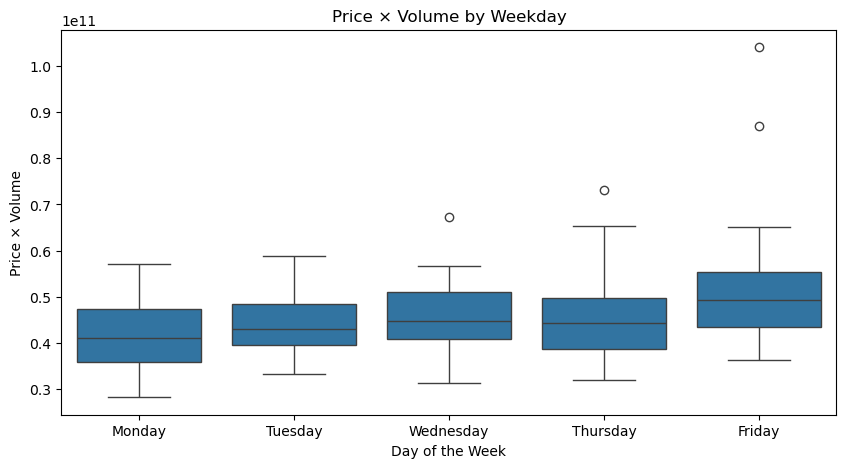

In [30]:
import seaborn as sns

# Define weekday order
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

# Boxplot with correct weekday order
plt.figure(figsize=(10,5))
sns.boxplot(x='weekday_name', y='price by volume', data=df, order=weekday_order)
plt.xlabel('Day of the Week')
plt.ylabel('Price × Volume')
plt.title('Price × Volume by Weekday')
plt.show()

In [31]:
# Overall skewness
print("Skewness of Price × Volume:", df['price by volume'].skew())
if df['price by volume'].skew() > 0:
    print('Skewed Right')
if df['price by volume'].skew() < 0:
    print('Skewed Left')
if df['price by volume'].skew() == 0:
    print('Roughly Symmetric')
print("Skewness of Volume:", df['volume'].skew())
if df['volume'].skew() > 0:
    print('Skewed Right')
if df['volume'].skew() < 0:
    print('Skewed Left')
if df['volume'].skew() == 0:
    print('Roughly Symmetric')
print("Skewness of Close:", df['close'].skew())
if df['close'].skew() > 0:
    print('Skewed Right')
if df['close'].skew() < 0:
    print('Skewed Left')
if df['close'].skew() == 0:
    print('Roughly Symmetric')

Skewness of Price × Volume: 2.016140537163028
Skewed Right
Skewness of Volume: 1.990492251784341
Skewed Right
Skewness of Close: -0.30556616141024695
Skewed Left


In [32]:
# Skewness of Price × Volume by day of week
skew_by_day = df.groupby('day_of_week')['price by volume'].skew()

# Map numeric day to names for readability
weekday_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday'}
skew_by_day.index = skew_by_day.index.map(weekday_names)

# Interpret skewness for each day
for day, skew in skew_by_day.items():
    if skew > 0:
        interpretation = 'Skewed Right: Investors should be aware of potential for extreme gains'
    elif skew < 0:
        interpretation = 'Skewed Left: Could indicate risk of sharp losses or market inactivity'
    else:
        interpretation = 'Roughly Symmetric: Daily price changes or trading volume are more predictable'
    print(f"{day}: {skew:.2f} → {interpretation}")

# Print the skew values as well
print("\nSkewness values by day:")
print(skew_by_day)

Monday: 0.12 → Skewed Right: Investors should be aware of potential for extreme gains
Tuesday: 0.68 → Skewed Right: Investors should be aware of potential for extreme gains
Wednesday: 0.56 → Skewed Right: Investors should be aware of potential for extreme gains
Thursday: 1.04 → Skewed Right: Investors should be aware of potential for extreme gains
Friday: 1.96 → Skewed Right: Investors should be aware of potential for extreme gains

Skewness values by day:
day_of_week
Monday       0.124522
Tuesday      0.684389
Wednesday    0.561604
Thursday     1.043085
Friday       1.964639
Name: price by volume, dtype: float64


In [98]:
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

# Ensure your DataFrame has a datetime index and close prices
df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)

# Create log prices and log returns
df['log_close'] = np.log(df['close'])
df['log_return'] = df['log_close'].diff()

# Drop missing values
df = df.dropna(subset=['log_return']).reset_index(drop=True)

# Quick check
print(df[['date', 'close', 'log_return']].head())

        date   close  log_return
0 2025-06-05  593.05   -0.004844
1 2025-06-06  599.14    0.010217
2 2025-06-09  599.68    0.000901
3 2025-06-10  603.08    0.005654
4 2025-06-11  601.36   -0.002856


In [100]:
# Use 80% for training and 20% for testing
split = int(len(df) * 0.8)

train_returns = df['log_return'].iloc[:split]
test_returns = df['log_return'].iloc[split:]

train_dates = df['date'].iloc[:split]
test_dates = df['date'].iloc[split:]

print(f"Train size: {len(train_returns)}, Test size: {len(test_returns)}")

Train size: 79, Test size: 20


In [102]:
# Automatically find best (p,d,q)
arima_model = auto_arima(
    train_returns,
    seasonal=False,
    stepwise=True,
    suppress_warnings=True,
    max_p=5,
    max_q=5,
    d=0,
    trace=True
)

print(arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-584.653, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-583.683, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-585.262, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-584.236, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-586.354, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-584.737, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-585.358, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-588.098, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-585.739, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-584.826, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-591.731, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-588.634, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-589.928, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-589.791, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept

In [106]:
# Forecast the same length as test set
n_periods = len(test_returns)
forecast_returns, confint = arima_model.predict(n_periods=n_periods, return_conf_int=True)

# Reconstruct predicted prices from last known training close
last_train_close = df['close'].iloc[split]

predicted_prices = [last_train_close]
for r in forecast_returns:
    predicted_prices.append(predicted_prices[-1] * np.exp(r))
predicted_prices = predicted_prices[1:]

# Create comparison DataFrame
results = pd.DataFrame({
    'date': test_dates.values,
    'actual_close': df['close'].iloc[split:].values,
    'predicted_close': predicted_prices
})
results.head()

,date,actual_close,predicted_close
0,2025-09-29,663.68,663.289900
1,2025-09-30,666.18,665.304866
2,2025-10-01,668.45,665.200362
3,2025-10-02,669.22,666.967902
4,2025-10-03,669.21,667.086195


In [110]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Calculate metrics
mse = mean_squared_error(results['actual_close'], results['predicted_close'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(results['actual_close'], results['predicted_close'])

print("ARIMA Test Metrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

ARIMA Test Metrics:
MSE: 69.1202
RMSE: 8.3139
MAE: 6.4080


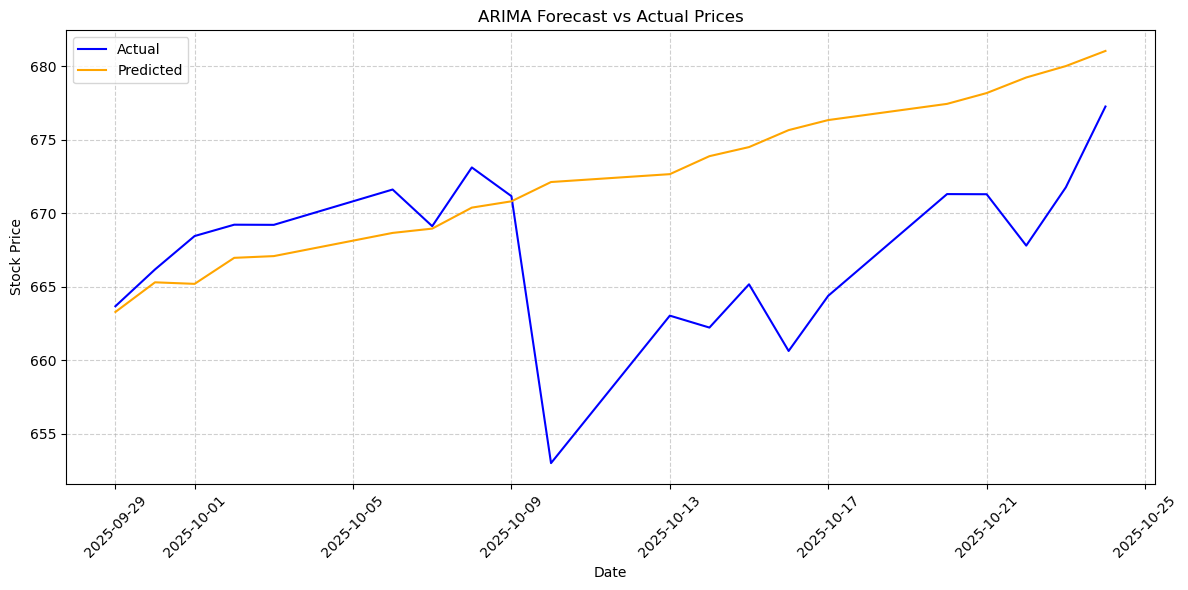

In [116]:
# Visualize predictions
plt.figure(figsize=(12,6))
plt.plot(results['date'], results['actual_close'], label='Actual', color='blue')
plt.plot(results['date'], results['predicted_close'], label='Predicted', color='orange')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('ARIMA Forecast vs Actual Prices')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

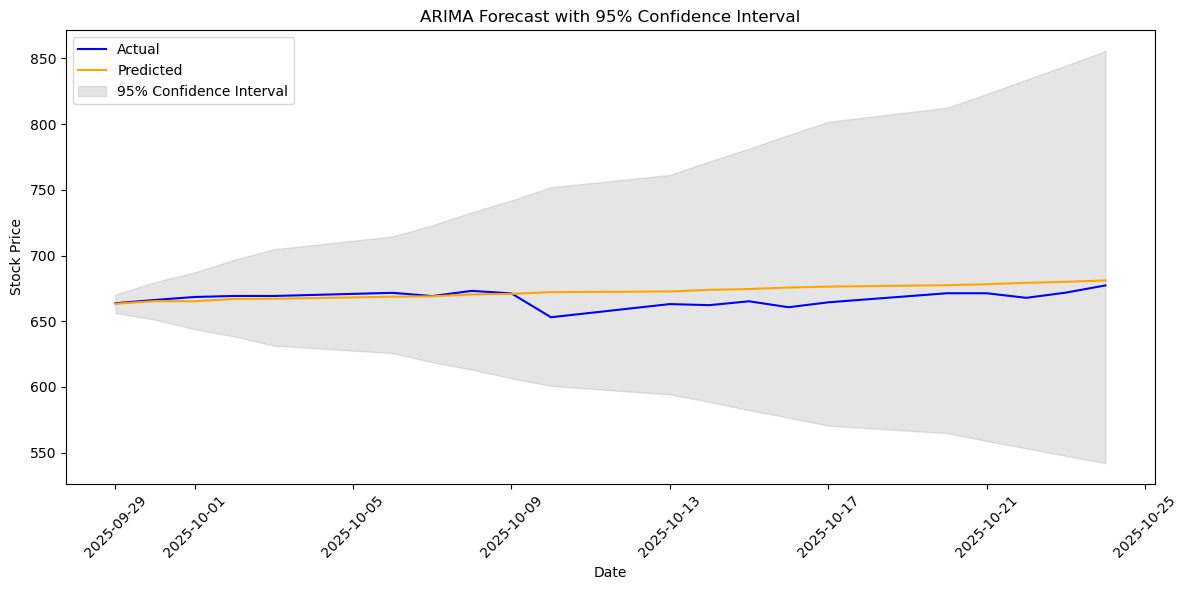

In [118]:
plt.figure(figsize=(12,6))
plt.plot(results['date'], results['actual_close'], label='Actual', color='blue')
plt.plot(results['date'], results['predicted_close'], label='Predicted', color='orange')

# Plot 95% confidence intervals
confint_df = pd.DataFrame(confint, columns=['lower', 'upper'], index=test_dates)
plt.fill_between(confint_df.index, 
                 np.exp(np.log(last_train_close) + confint_df['lower'].cumsum()),
                 np.exp(np.log(last_train_close) + confint_df['upper'].cumsum()),
                 color='gray', alpha=0.2, label='95% Confidence Interval')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.title('ARIMA Forecast with 95% Confidence Interval')
plt.legend()
plt.tight_layout()
plt.show()